<a href="https://colab.research.google.com/github/MereumF/EMBSEEGCOMP/blob/main/DecisionTreeEEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Identify whether a CUDA-enabled GPU is available
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    msg ='CUDA-enabled GPU found. Training should be faster.'
else:
    msg = (
        "No GPU found. Training will be carried out on CPU, which might be "
        "slower.\n\nIf running on Google Colab, you can request a GPU runtime by"
        " clicking\n`Runtime/Change runtime type` in the top bar menu, then "
        "selecting \'T4 GPU\'\nunder \'Hardware accelerator\'."
    )
print(msg)

In [1]:
#@title ▶️ Install additional required packages for colab
!pip install braindecode
!pip install eegdash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 

In [2]:
#@title ▶️ Run this first to get all the utils functions for the epoching
from braindecode.datasets import BaseConcatDataset


In [3]:
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

from eegdash.dataset import EEGChallengeDataset

dataset_ccd = EEGChallengeDataset(task="contrastChangeDetection",
                                  release="R1", cache_dir=DATA_DIR,
                                  mini=True)


╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=496687;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=550700;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

In [ ]:
#Challenge 1 starter kit
#0.5 sec = 500 ms
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from eegdash.hbn.windows import (
    annotate_trials_with_target,
    add_aux_anchors,
    add_extras_columns,
    keep_only_recordings_with,
)

EPOCH_LEN_S = 2.0
SFREQ = 100 # by definition here

transformation_offline = [
    Preprocessor(
        annotate_trials_with_target,
        target_field="rt_from_stimulus", epoch_length=EPOCH_LEN_S,
        require_stimulus=True, require_response=True,
        apply_on_array=False,
    ),
    Preprocessor(add_aux_anchors, apply_on_array=False),
]
preprocess(dataset_ccd, transformation_offline, n_jobs=1)

ANCHOR = "stimulus_anchor"

SHIFT_AFTER_STIM = 0.5
WINDOW_LEN       = 2.0

# Keep only recordings that actually contain stimulus anchors
dataset = keep_only_recordings_with(ANCHOR, dataset_ccd)

# Create single-interval windows (stim-locked, long enough to include the response)
single_windows = create_windows_from_events(
    dataset,
    mapping={ANCHOR: 0},
    trial_start_offset_samples=int(SHIFT_AFTER_STIM * SFREQ),                 # +0.5 s
    trial_stop_offset_samples=int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),   # +2.5 s
    window_size_samples=int(EPOCH_LEN_S * SFREQ),
    window_stride_samples=SFREQ,
    preload=True,
)

# Injecting metadata into the extra mne annotation.
single_windows = add_extras_columns(
    single_windows,
    dataset,
    desc=ANCHOR,
    keys=("target", "rt_from_stimulus", "rt_from_trialstart",
          "stimulus_onset", "response_onset", "correct", "response_type")
          )

In [5]:
# for each windows, we can extract the metainformation using:

meta_information = single_windows.get_metadata()

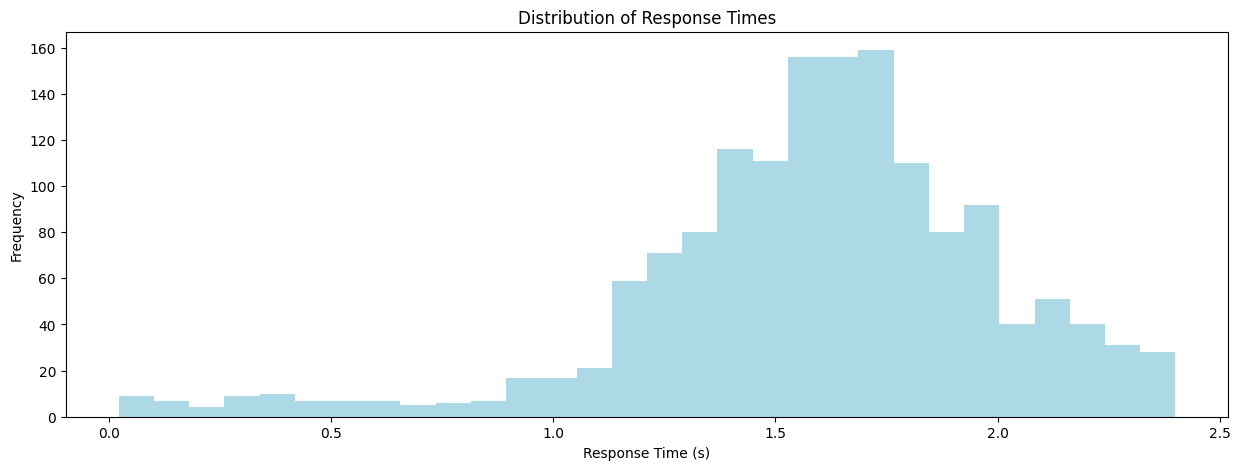

In [6]:
from matplotlib.pylab import plt

fig, ax = plt.subplots(figsize=(15, 5))
ax = meta_information["target"].plot.hist(bins=30, ax=ax, color='lightblue')
ax.set_xlabel("Response Time (s)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Response Times")
plt.show()


In [7]:
import numpy as np
male = 0
female = 0

subject_ids = meta_information["subject"].unique()
print("Subject ID's: ", subject_ids)
print("Ages: ", meta_information["age"].unique())

participants_summary = meta_information[['subject', 'sex']].drop_duplicates()

for i in participants_summary['sex']:
  if i == 'M':
    male +=1
  elif i == 'F':
    female +=1
print("Num of Males: ", male, ". Num of Females: ", female)


Subject ID's:  ['NDARAC904DMU' 'NDARAM704GKZ' 'NDARAP359UM6' 'NDARBD879MBX'
 'NDARBH024NH2' 'NDARBK082PDD' 'NDARCA153NKE' 'NDARCE721YB5'
 'NDARCJ594BWQ' 'NDARCN669XPR' 'NDARCW094JCG' 'NDARCZ947WU5'
 'NDARDH670PXH' 'NDARDL511UND' 'NDARDU986RBM' 'NDAREM731BYM'
 'NDAREN519BLJ' 'NDARFK610GY5' 'NDARFT581ZW5' 'NDARFW972KFQ']
Ages:  [11.3386 10.9449 12.8422 13.9757  8.6883  8.3652  6.7472  6.6821 12.4585
  9.6883  8.453   9.3646 13.0092 10.2002  9.926  11.8507  7.0291 10.5204
  6.7034 12.4397]
Num of Males:  12 . Num of Females:  8


In [49]:
num_cols = meta_information.select_dtypes(include=['int64', 'float64', 'Int64', 'Float64']).columns.tolist()

# drop the non-feature number columns
drop_cols = ['run', 'i_window_in_trial', 'i_start_in_trial', 'i_stop_in_trial', 'release_number', 'target', 'rt_from_stimulus', 'correct']

num_cols = [col for col in num_cols if col not in drop_cols]
print(num_cols)


['rt_from_trialstart', 'stimulus_onset', 'response_onset', 'age', 'ehq_total', 'p_factor', 'attention', 'internalizing', 'externalizing']


In [50]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
categorical_column = meta_information[['sex']]
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(categorical_column)

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['sex']))
one_hot_df.reset_index(drop=True, inplace=True)

numerical_df = meta_information[num_cols].reset_index(drop=True)

df_final = pd.concat([numerical_df, one_hot_df], axis=1)


In [51]:
df_final.head()

,rt_from_trialstart,stimulus_onset,response_onset,age,ehq_total,p_factor,attention,internalizing,externalizing,sex_F,sex_M
0,4.93,42.284,44.414,11.3386,71.17,-0.603,-0.446,1.248,0.325,1.0,0.0
1,4.76,47.484,49.444,11.3386,71.17,-0.603,-0.446,1.248,0.325,1.0,0.0
2,6.42,54.284,56.304,11.3386,71.17,-0.603,-0.446,1.248,0.325,1.0,0.0
3,7.72,62.684,64.404,11.3386,71.17,-0.603,-0.446,1.248,0.325,1.0,0.0
4,4.6,67.884,69.684,11.3386,71.17,-0.603,-0.446,1.248,0.325,1.0,0.0


In [52]:
feature_columns = num_cols
y = meta_information["rt_from_stimulus"].values
X = df_final.values

In [53]:
print(y.shape)
print(X.shape)

(1513,)
(1513, 11)


In [54]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")


Train: 1210, Test: 303


In [55]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the regressor
dec_tree = DecisionTreeRegressor(random_state=42, max_depth=None)

# Fit the model
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [56]:
from numpy import std
from sklearn.metrics import root_mean_squared_error as rmse


# Predictions
y_train_pred = dec_tree.predict(X_train) #error on known data

y_preds = dec_tree.predict(X_test) #how does model fit the new data

print("TRAIN RMSE: ", rmse(y_train, y_train_pred) / std(y_train))

print("TEST RMSE: ", rmse(y_test, y_preds) / std(y_test))


TRAIN RMSE:  3.588656914499753e-14
TEST RMSE:  0.9160859283857149


In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [34]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=dec_tree, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=2)

In [58]:
best_dtree_reg = grid_search.best_estimator_ # Get the best estimator from the grid search

# Best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Cross-Validation Accuracy: -0.08195659436438578


In [59]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the regressor
dec_tree_best = DecisionTreeRegressor(random_state=42, max_depth=20, min_samples_leaf = 4, min_samples_split = 10)

# Fit the model
dec_tree_best.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                      random_state=42)

In [61]:
from numpy import std
from sklearn.metrics import root_mean_squared_error as rmse


# Predictions
y_train_pred = dec_tree_best.predict(X_train) #error on known data
y_preds = dec_tree_best.predict(X_test) #how does model fit the new data

print("TRAIN RMSE: ", rmse(y_train, y_train_pred) / std(y_train))

print("TEST RMSE: ", rmse(y_test, y_preds) / std(y_test))


TRAIN RMSE:  0.5127893012853912
TEST RMSE:  0.6526781285049293


In [62]:
#https://machinelearningmastery.com/calculate-feature-importance-with-python/
importance = dec_tree_best.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.75056
Feature: 1, Score: 0.00825
Feature: 2, Score: 0.00785
Feature: 3, Score: 0.00062
Feature: 4, Score: 0.01591
Feature: 5, Score: 0.13746
Feature: 6, Score: 0.03013
Feature: 7, Score: 0.02182
Feature: 8, Score: 0.01802
Feature: 9, Score: 0.00938
Feature: 10, Score: 0.00000


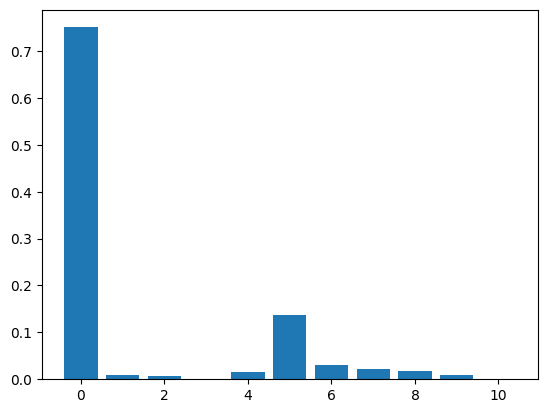

In [63]:
from matplotlib import pyplot

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [66]:
from xgboost import XGBRegressor

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [68]:
from numpy import std
from sklearn.metrics import root_mean_squared_error as rmse


# Predictions
y_train_pred_XGB = XGBmodel.predict(X_train) #error on known data
y_preds_XGB = XGBmodel.predict(X_test) #how does model fit the new data

print("TRAIN RMSE: ", rmse(y_train, y_train_pred_XGB) / std(y_train))

print("TEST RMSE: ", rmse(y_test, y_preds_XGB) / std(y_test))


TRAIN RMSE:  0.04583358569679438
TEST RMSE:  0.6202468808688222


Feature: 0, Score: 0.17924
Feature: 1, Score: 0.05241
Feature: 2, Score: 0.03768
Feature: 3, Score: 0.11601
Feature: 4, Score: 0.10537
Feature: 5, Score: 0.19105
Feature: 6, Score: 0.05905
Feature: 7, Score: 0.04533
Feature: 8, Score: 0.06930
Feature: 9, Score: 0.14456
Feature: 10, Score: 0.00000


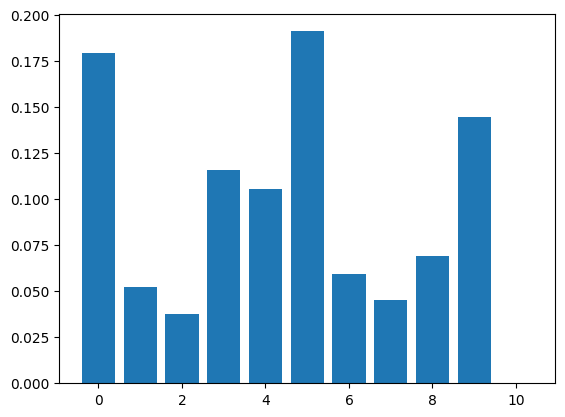

In [69]:
importance = XGBmodel.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()